# Calibration
## Goal Map pixels to inches / feet
We need to transfer observations from x-y pixel space to physical units

## imports


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## functions


### frame space

In [ ]:
def get_frame(cap, n):
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    return cap.read()

def get_video_parameters(cap):
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return fps, width, height, frame_count

def find_circles_hough(frame: np.ndarray, 
    param2: int=7,
    min_radius: int=5, max_radius: int=8,
) -> np.ndarray:
    """ Finds circles in a cv2 frame."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)        # create grayscale copy
    return cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                        param1=50, param2=param2, 
                        minRadius=min_radius, maxRadius=max_radius)

In [ ]:
# ballphsics/vision/utils.py
def extract_vertical_slice(frame: np.ndarray, x_start: int, x_end: int) -> np.ndarray:
    """Extract a vertical slice from frame between x_start and x_end."""
    return frame[:, x_start:x_end]

def extract_horizontal_slice(frame: np.ndarray, y_start: int, y_end: int) -> np.ndarray:
    """Extract a horizontal slice from frame between y_start and y_end."""
    return frame[y_start:y_end, :]

def extract_region(frame: np.ndarray, x_start: int, x_end: int, y_start: int, y_end: int) -> np.ndarray:
    """Extract a rectangular region from frame."""
    return frame[y_start:y_end, x_start:x_end]


In [ ]:
def rotate_points(points, angle_degrees):
    angle_rad = np.radians(angle_degrees)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    return points @ rotation_matrix.T

### visualization

In [ ]:
# ballphysics/visualization/plotting.py
def view_frame(frame, h=10, w=12):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(h, w))
    plt.imshow(frame_rgb)
    plt.gca().xaxis.set_ticks_position('both')
    plt.tick_params(top=True, labeltop=True)
    plt.show()


def show_frames_side_by_side(frame1, frame2, title1='Frame 1', title2='Frame 2'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
    
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(frame1_rgb)
    ax1.set_title(title1)
    ax1.axis('on')
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(top=True, labeltop=True)

    ax2.imshow(frame2_rgb)
    ax2.set_title(title2)
    ax2.axis('on')
    ax2.xaxis.set_ticks_position('both')
    ax2.tick_params(top=True, labeltop=True)
    
    plt.tight_layout()
    plt.show()

### analysis


In [ ]:
def rotate_points(points, angle_degrees):
    angle_rad = np.radians(angle_degrees)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    return points @ rotation_matrix.T

## video path


In [ ]:
freefall_path = "../data/freefall.mp4"

## video characteristics

In [ ]:
cap = cv2.VideoCapture(freefall_path)

In [ ]:
fps, width, height, frame_count = get_video_parameters(cap)
"width and height", width, height, "frame count and fps", frame_count, fps

('width and height', 2160, 3840, 'frame count and fps', 74, 54.7087743509494)

## is pegboard backdrop vertical
- Use the pegboard to allow a transform from pixel space to physical space.
- Ideally it should be vertical and the camera should be horizontal
- If possible confirm vertical pegboard with level or plumb
- Confirm camera plumb from photo before taking videos.

### Not in this video
- From measurements of the ball trajectory - camera was 2.14° out of level


### camera was 2.14° out of level


In [ ]:
ret, frame = get_frame(cap, 0)


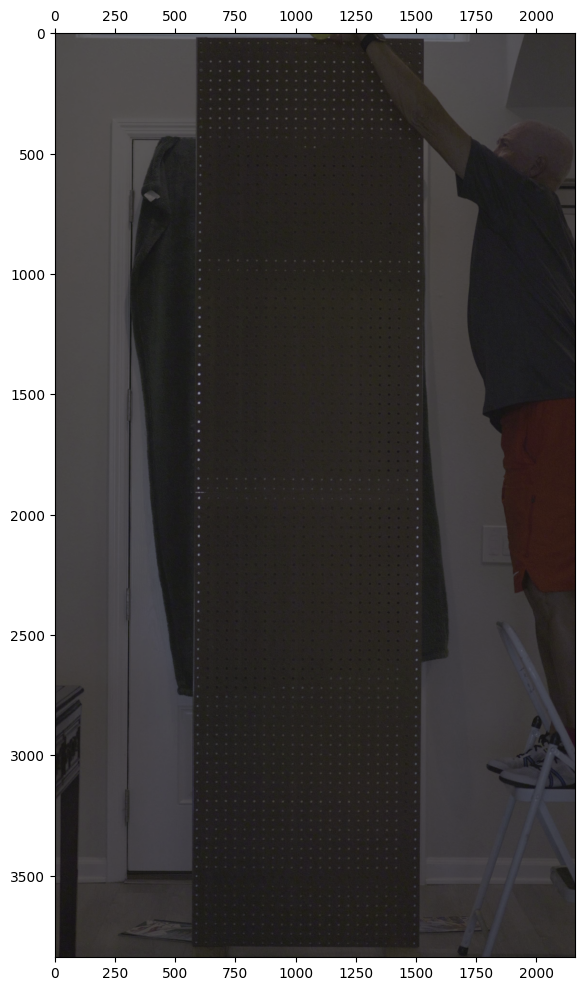

In [ ]:
#| export
view_frame(frame)

#### Characteristics of the board
- Attached to metal studs on each side with screws
- Wood supports to keep the metal studs square
- Outside peg holes show the metal
- Where the wood supports are the holes are different
- Other holes have mixed lighting levels behind the backdrop

In [ ]:
f_top = extract_horizontal_slice(frame, 0, 300)
f_bot = extract_horizontal_slice(frame, height - 300, height)


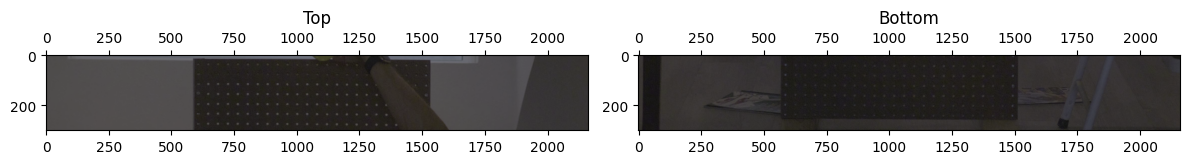

In [ ]:
show_frames_side_by_side(f_top, f_bot, "Top", "Bottom")


#### further crop vertically to examine the left edge

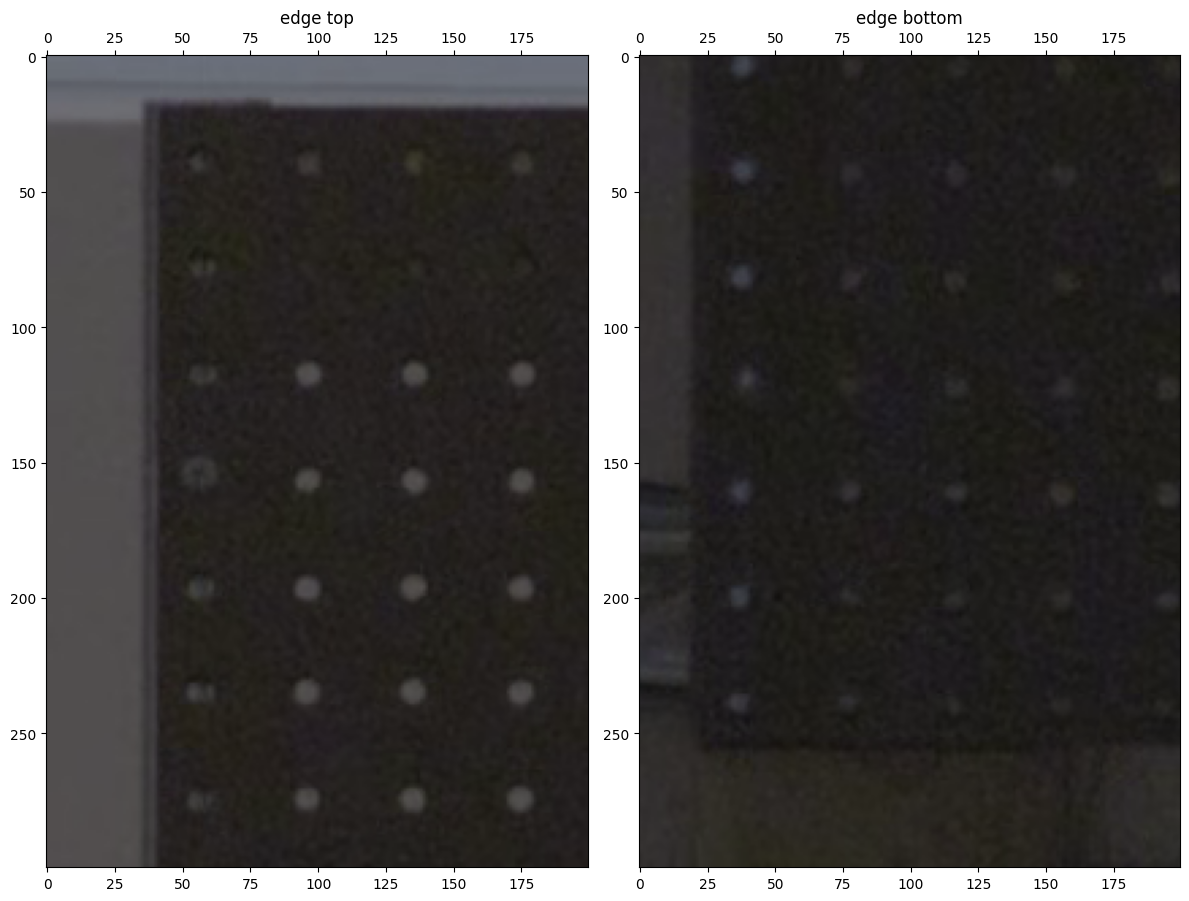

In [ ]:
left = 550
right = 750
edge_top = f_top[:, left:right]
edge_bot = f_bot[:, left:right]
show_frames_side_by_side(edge_top, edge_bot, "edge top", "edge bottom")

## Crop the full frame vertically to locate the peg holes

In [ ]:
left = 600
right = 1200

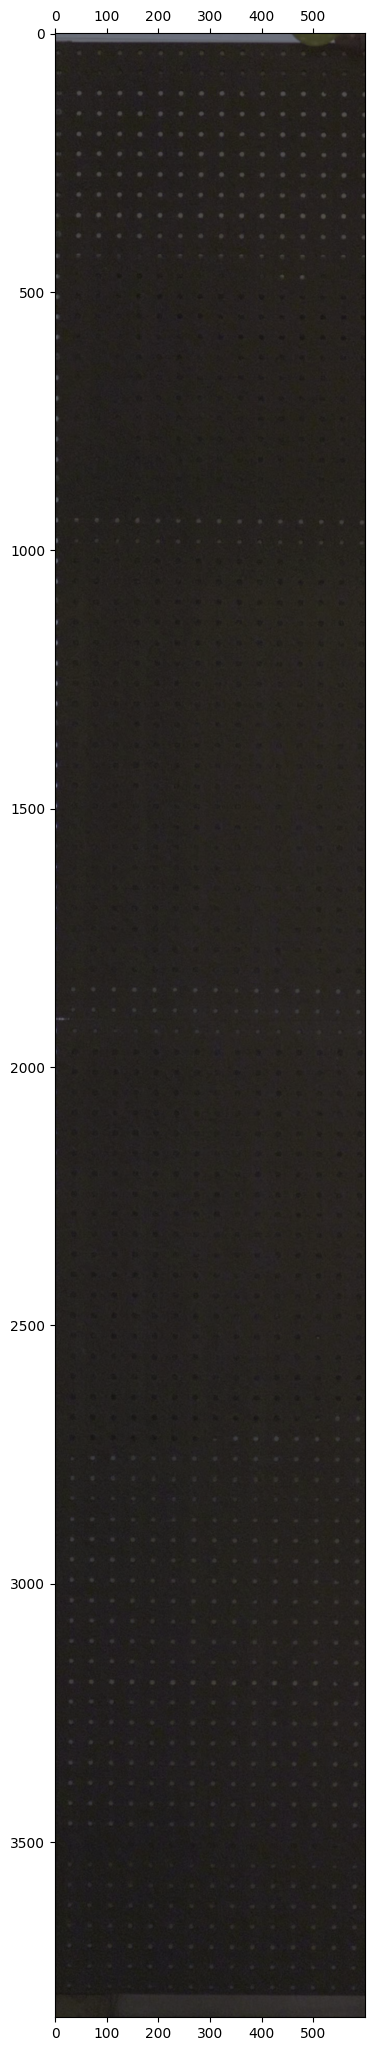

In [ ]:
vertical_slice = frame[:, left:right]
view_frame(vertical_slice, h=4, w=800)

### Refine Hough parameters to identify circles

#### Eyeballing the slice above - Try 8 as a maximum radius

In [ ]:
min_radius = 5
max_radius = 8

print(f"Radius  min {min_radius} max {max_radius}")
for par2 in range(1,9):
    circles = find_circles_hough(vertical_slice, param2=par2, min_radius=min_radius, max_radius=max_radius)
    circle_count = 0
    if circles is not None:
        circle_count = len(circles[0])
    print(f"param2 value {par2:2d}  - No of circles found {circle_count:4d}")

Radius  min 5 max 8
param2 value  1  - No of circles found 1465
param2 value  2  - No of circles found 1284


param2 value  3  - No of circles found 1099
param2 value  4  - No of circles found  921
param2 value  5  - No of circles found  706
param2 value  6  - No of circles found  421


param2 value  7  - No of circles found  222
param2 value  8  - No of circles found  105


#### Experiment with par2
Maximize positives, minimize false positives

In [ ]:
par2 = 7
min_radius = 5
max_radius = 8
# result = input("param2")
# par2 = int(result)
# max_radius = input("max_radius")
# max_radius = int(max_radius)

#### Find circles in a vertical slice

In [ ]:
circles = find_circles_hough(vertical_slice, param2=7, min_radius=5, max_radius=8)
circle_count = len(circles)

In [ ]:
def show_circles_found(frame, circles):
    green = (0, 255, 0)
    red = (0, 0, 255)
    result = frame.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(result, (i[0], i[1]), i[2], green, 2)
            cv2.circle(result, (i[0], i[1]), 2, red, 3)
    view_frame(result, h=4, w=800)

#### Distribution of circle radii

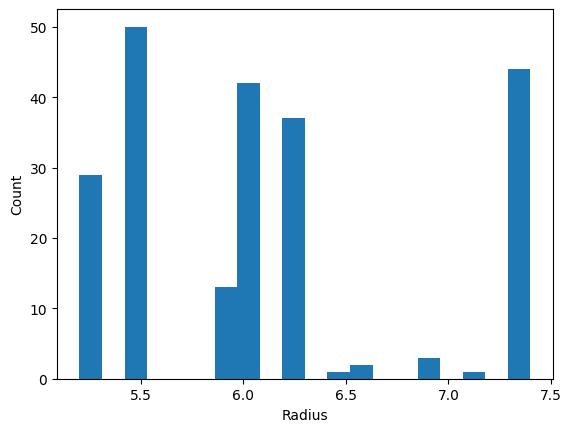

In [ ]:
if circles is not None:
    radii = circles[0, :, 2]
    plt.hist(radii, bins=20)
    plt.xlabel('Radius')
    plt.ylabel('Count')
    plt.show()

#### Use k-means clustering to select clusters of vertical holes

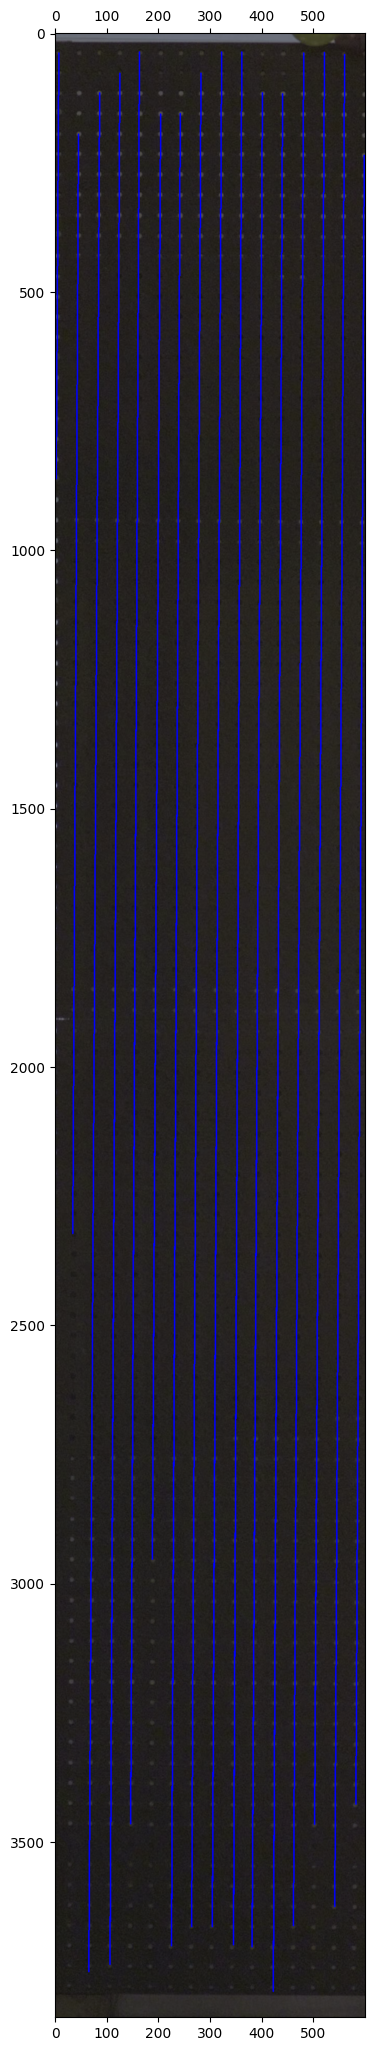

In [ ]:
from sklearn.cluster import KMeans

# Extract circle centers
centers = circles[0, :, :2]  # x, y coordinates

# Cluster by x-coordinate (adjust n_clusters based on how many columns you expect)
nclusters = 16
kmeans = KMeans(n_clusters=nclusters, random_state=42)
labels = kmeans.fit_predict(centers[:, 0].reshape(-1, 1))

# Fit a line to each cluster
result_lines = vertical_slice.copy()
for cluster_id in range(nclusters):
    cluster_points = centers[labels == cluster_id]
    if len(cluster_points) > 1:
        # Fit line: y = mx + b
        coeffs = np.polyfit(cluster_points[:, 1], cluster_points[:, 0], 1)
        
        # Draw the line
        y_min, y_max = int(cluster_points[:, 1].min()), int(cluster_points[:, 1].max())
        x_min = int(coeffs[0] * y_min + coeffs[1])
        x_max = int(coeffs[0] * y_max + coeffs[1])
        cv2.line(result_lines, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

view_frame(result_lines, h=4, w=800)

In [ ]:
print(np.bincount(labels))


[22 22 13 12  7 22 15 13 10 18  9 10 17 12 10 10]


#### Show results - angle from horizontal and hole spacing in pixels

In [ ]:
slopes = []
for cluster_id in range(nclusters):
    cluster_points = centers[labels == cluster_id]
    if len(cluster_points) > 1:
        coeffs = np.polyfit(cluster_points[:, 1], cluster_points[:, 0], 1)
        slopes.append(coeffs[0])

angles = np.degrees(np.arctan(slopes))
mean_angle = np.mean(angles)
print(f"Angles from vertical: {angles}")
print(f"Mean angle: {mean_angle:.3f} degrees")
print(f"Std dev: {np.std(angles):.3f} degrees")
all_gaps = []
for cluster_id in range(nclusters):
    cluster_points = centers[labels == cluster_id]
    if len(cluster_points) > 1:
        # Sort by y-coordinate
        cluster_sorted = cluster_points[cluster_points[:, 1].argsort()]
        # Rotate points
        rotated = rotate_points(cluster_sorted, mean_angle)
        # Calculate gaps
        gaps = np.fabs(np.diff(rotated[:, 1]))
        # Keep only gaps < 50 (1-inch spacings)
        small_gaps = gaps[gaps < 50]
        all_gaps.extend(small_gaps)

x_pixels_per_inch = np.mean(all_gaps)
print(f"Pixels per inch - x direction: {x_pixels_per_inch:.2f}")
print(f"Number of gaps used: {len(all_gaps)}")

Angles from vertical: [-0.27945937 -0.31470182 -0.28814491 -0.3060024  -0.34834142 -0.28190478
 -0.24112808 -0.28483198 -0.32733847 -0.3172992  -0.29576383 -0.28339269
 -0.29220498 -0.29502379 -0.32948248 -0.31195719]
Mean angle: -0.300 degrees
Std dev: 0.025 degrees
Pixels per inch - x direction: 39.47
Number of gaps used: 49


## Crop the full frame horizontally to locate the peg holes

In [ ]:
left   =  600
right  = 1200
top    =  100
bottom = 3500
horizontal_slice1 = frame[top:bottom, left:right]

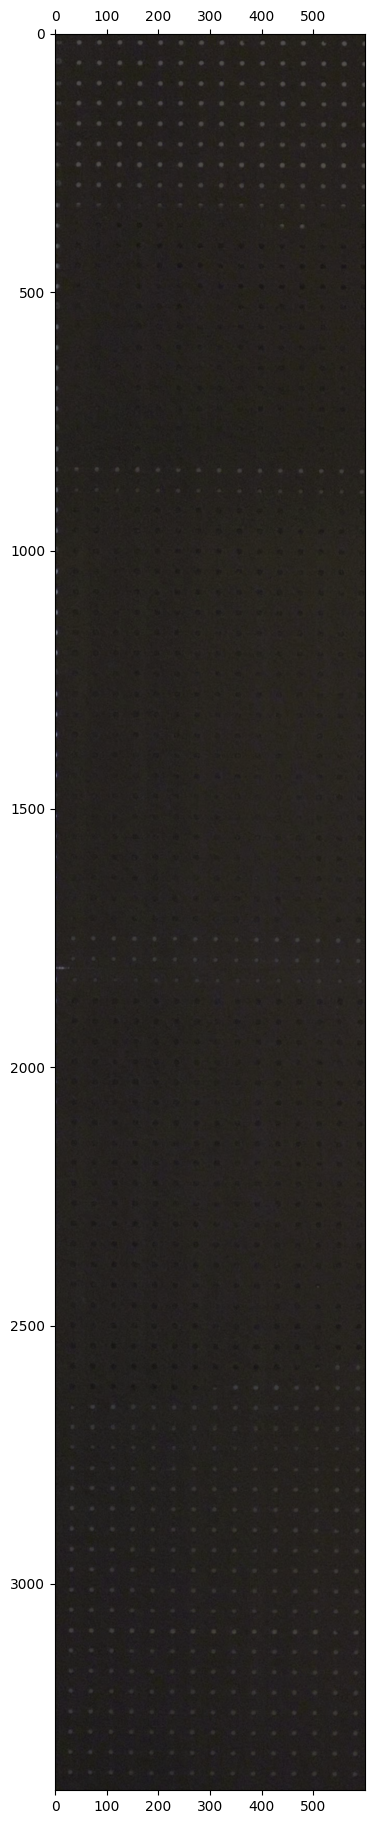

In [ ]:
view_frame(horizontal_slice1, h=4, w=800)

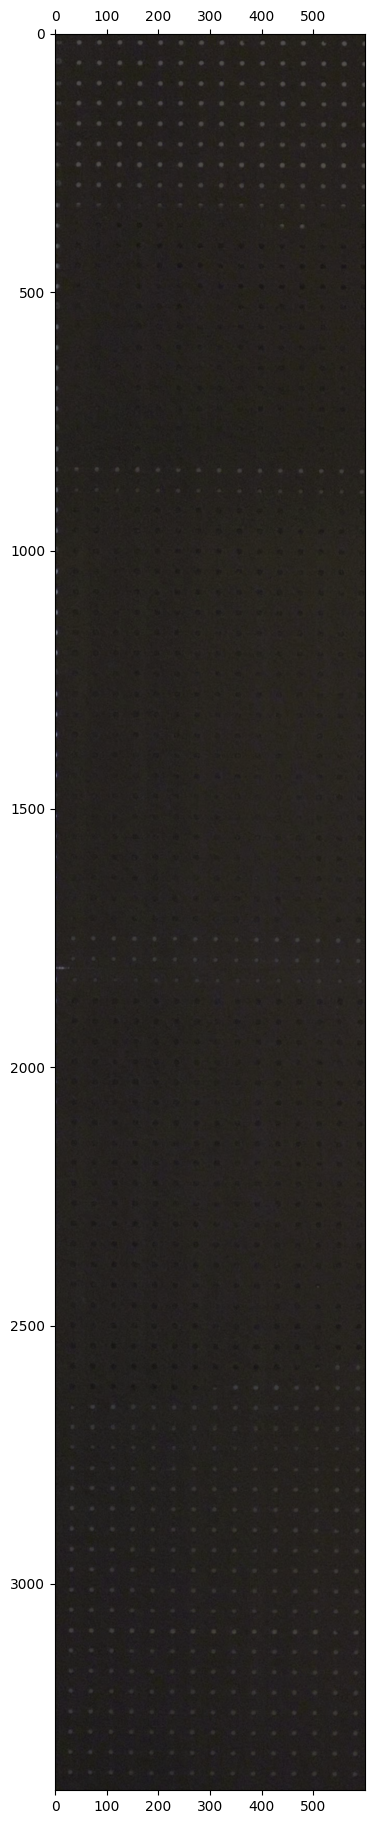

In [ ]:
view_frame(horizontal_slice1, h=4, w=800)

Radius  min 5 max 8
param2 value  6  - No of circles found  356


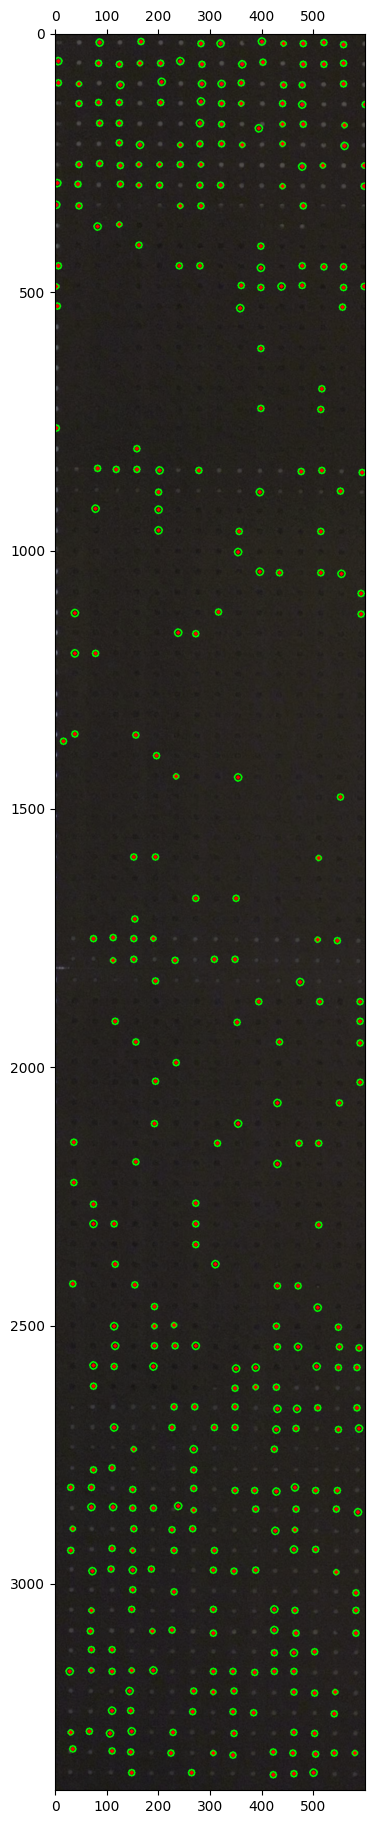

In [ ]:
min_radius = 5
max_radius = 8

print(f"Radius  min {min_radius} max {max_radius}")
for par2 in range(6,7):
    circles = find_circles_hough(horizontal_slice1, param2=par2, min_radius=min_radius, max_radius=max_radius)
    circle_count = 0
    if circles is not None:
        circle_count = len(circles[0])
    print(f"param2 value {par2:2d}  - No of circles found {circle_count:4d}")

show_circles_found(horizontal_slice1, circles)

#### Distribution of circle radii

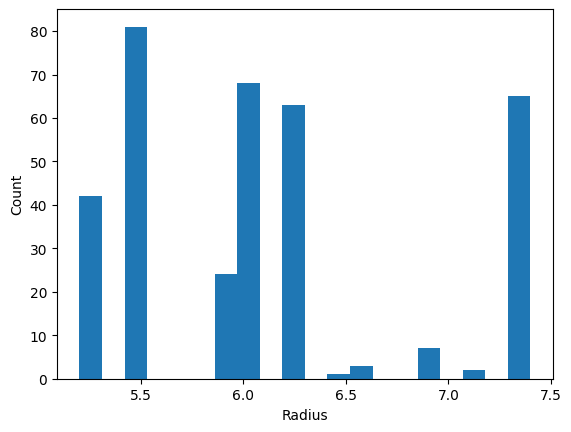

In [ ]:
if circles is not None:
    radii = circles[0, :, 2]
    plt.hist(radii, bins=20)
    plt.xlabel('Radius')
    plt.ylabel('Count')
    plt.show()

#### Use k-means clustering to select clusters of horizontal holes

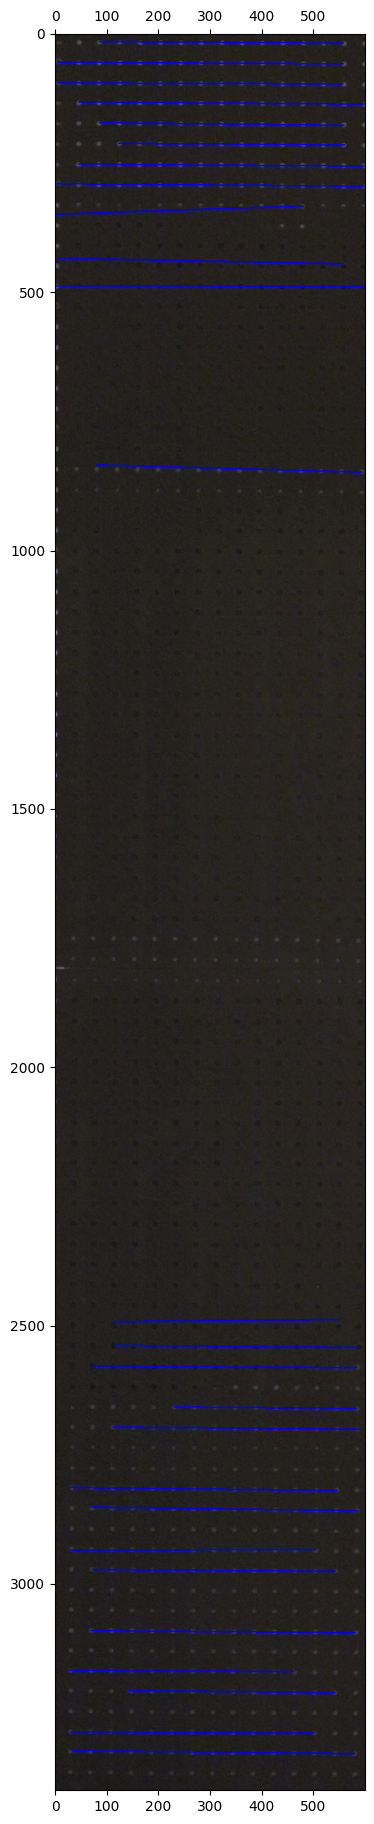

In [ ]:
nclusters = 60
# Extract circle centers
centers = circles[0, :, :2]  

# x, y coordinates# Cluster by y-coordinate (for horizontal rows)
kmeans = KMeans(n_clusters=nclusters, random_state=42)
labels = kmeans.fit_predict(centers[:, 1].reshape(-1, 1))

good_clusters = []
# Fit a line to each cluster
result_lines = horizontal_slice1.copy()
for cluster_id in range(nclusters):
    cluster_points = centers[labels == cluster_id]
    if len(cluster_points) > 6:
        # Fit line: x = my + b
        coeffs = np.polyfit(cluster_points[:, 0], cluster_points[:, 1], 1)
        
        x_min, x_max = int(cluster_points[:, 0].min()), int(cluster_points[:, 0].max())
        y_min = int(coeffs[0] * x_min + coeffs[1])
        y_max = int(coeffs[0] * x_max + coeffs[1])
        cv2.line(result_lines, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        
        y_variance = np.fabs(y_max - y_min)
        # print(f"Cluster {cluster_id}: {coeffs} {len(cluster_points)} points, y_variance: {y_variance:.2f}")

        if y_variance < 10 and coeffs[0] > 0:
        # Draw the line
            x_min, x_max = int(cluster_points[:, 0].min()), int(cluster_points[:, 0].max())
            y_min = int(coeffs[0] * x_min + coeffs[1])
            y_max = int(coeffs[0] * x_max + coeffs[1])
            cv2.line(result_lines, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            good_clusters.append((cluster_id, len(cluster_points)))

        # else:
        #     print(f"Excluding Cluster {cluster_id}") 

view_frame(result_lines, h=4, w=800)

In [ ]:
len(good_clusters), sum(count for _, count in good_clusters)

(21, 185)

#### Show results - angle from vertical and hole spacing in pixels

In [ ]:
slopes = []
for good_cluster in good_clusters:
    cluster_points = centers[labels == good_cluster[0]]
    if len(cluster_points) > 1:
        coeffs = np.polyfit(cluster_points[:, 1], cluster_points[:, 0], 1)
        slopes.append(coeffs[0])

angles = np.degrees(np.arctan(slopes))
mean_angle = np.mean(angles)
print(f"Angles from vertical: {angles}")
print(f"Mean angle: {mean_angle:.3f} degrees")
print(f"Std dev: {np.std(angles):.3f} degrees")


all_gaps = []
for good_cluster in good_clusters:
    cluster_points = centers[labels == good_cluster[0]]

    if len(cluster_points) > 1:
        # Sort by y-coordinate
        cluster_sorted = cluster_points[cluster_points[:, 1].argsort()]
        # Rotate points
        rotated = rotate_points(cluster_sorted, mean_angle)
        # Calculate gaps
        gaps = np.fabs(np.diff(rotated[:, 1]))
        # Keep only gaps < 50 (1-inch spacings)
        small_gaps = gaps[gaps < 50]
        all_gaps.extend(small_gaps)

y_pixels_per_inch = np.mean(all_gaps)
print(f"Pixels per inch y direction: {y_pixels_per_inch:.2f}")
print(f"Number of gaps used: {len(all_gaps)}")

Angles from vertical: [89.27870832 88.48640197 88.73677264 88.27192743 89.15626539 89.1700186
 88.8289022  89.01066051 88.61900623 88.61565438 88.5603183  88.589283
 88.6295302  88.73604803 89.30606537 89.46740832 88.53609315 89.46679139
 87.75664885 89.07113085 89.09107317]
Mean angle: 88.828 degrees
Std dev: 0.412 degrees
Pixels per inch y direction: 39.44
Number of gaps used: 36


In [ ]:
print(f"Pixels per inch x direction: {x_pixels_per_inch:.2f}")
print(f"Pixels per inch y direction: {y_pixels_per_inch:.2f}")


Pixels per inch x direction: 39.47
Pixels per inch y direction: 39.44
